#Reception of Films from Locations and Genres

##Table of Contents
* [Reception of Films from Locations and Genres](#Reception-of-Films-from-Locations-and-Genres)
    * [1. Overview](#1.-Overview)
	* [2. Data Acquisition & Management](#2.-Data-Acquisition-&-Management)
        * [2.1. Approach 1](#2.1.-Approach-1)
        * [2.2. Approach 2](#2.2.-Approach-2)
        * [2.3. Implementing Approach 1](#2.3.-Implementing Approach-1)
    * [3. Analyses](#3.-Analyses)
        * [3.1. Summary Statistics of Data Set](#3.1.-Summary-Statistics-of-Data-Set)
        * [3.2. Linear Regression](#3.2.-Linear-Regression)
        * [3.3. Principal Component Analysis](#3.3.-Principal-Component-Analysis)
        * [3.4. Train-Test Splitting](#3.4.-Train-Test-Splitting)
        * [3.5. Baseline Accuracy](#3.5.-Baseline-Accuracy)
        * [3.6. Logistic Regression](#3.6.-Logistic-Regression)
        * [3.7. K-Nearest Neighbours](#3.7.-K-Nearest-Neighbours)
    * [4. Comparison](#4.-Comparison)


In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import time
import json
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import random

#1. Overview

In this project, we study the relationship between film reception and other factors like filming locations and genres. Data will be scraped from [IMDB](http://www.imdb.com). Linear regression will be used to study the effects of each feature (in this case, locations and genres) on user ratings. After which, Principal Component Analysis (PCA) will be used for to reduce the dimension of our data set. Then, logistic regression and k-Nearest Neighbours(kNN) will be used for classification in order to predict whether a film is well received. The accuracy of both estimators will be compared. Visualisation of results will be done via graphical plots and Tableau.

# 2. Data Acquisition & Management

We first scrape the data from IMDB which gives us information about each film title such as  the budget, country, critic ratings, duration, genre, gross earnings, language, filming locations, name, opening weekend earnings, release dates, url, user ratings, user ratings count and year. The code for web scraping can be found in a separate notebook. Though we planned to work with a data set of 12,000 titles initially, a preliminary test run of PCA with around 18,000 features of locations and genres, indicated that it was very computationally expensive. Instead, we reduce the size of our data to 10,000 titles. To do so, we scraped IMDB for all film titles from 2009 to 2014. Titles without user ratings, film locations and genres are then removed from our data set. Subsequently, we pick 10,000 titles randomly from the remaining pool of titles.

Next, we convert user ratings to a binary feature where "1" indicates that the film was well-received while "0" indicates otherwise. Initially, the threshold rating for determining if a film is well-received was not "5" nor was it a randomly chosen number. Instead, we looked at the spread of user ratings across our data. Films with ratings in the top 50% were assigned "1" while films in the bottom 50% were assigned "0". Though such conversion of user ratings might raise problems, the intention here is to have a balanced number for both sides; additionally, this technique can be applied to larger data sets where the threshold is determined by the data in hand. However, after some considerations, it was decided that "5" will be taken as the threshold since, intuitively, "5" is the boundary most people use when deliberating whether or not they like a film.

For locations, substantial data cleaning is required. This is largely due to film locations being user-contributed. Hence, we faced problems like spelling mistakes, multiple entries of similar details or details with trivial differences that were irrelevant to our study. For example, some locations are specific to the street while others merely state the country. In cleaning up the feature "locations", we considered two approaches which are elaborated below.

#### 2.1. Approach 1

We split the entries of "locations" for each title by the commas into phrases. This is because most entries take the form - (specific location),(city),(country) - with various titles having anomalous and repeated entries. Then, we restrict "locations" to cities and countries. Using a list of cities, that we acquired online, and countries across the world, we compared the locations in our data and the locations in the list. Phrases that appear in the list of cities and countries are kept while other location details are discarded. While this resulted in some problems, one particularly interesting issue was that many countries had names shared by cities. 

For example, China turned out to be the name of a city in Texas as well. As a result, if a film was filmed in China, Texas, it would be recorded as being filmed in the country China as well. However, given that these cities with similar names to countries are not especially known widely, we assume that such occurrences are rare anomalies. In addition, we chose to include countries so as to mitigate this problem since our hypothetical film will be recorded as being filmed in China and USA. As such, it is true that the film was filmed in USA but merely a rare anomaly that it is erroneously recorded to be filmed in China too.

While Approach 2 below was also considered, Approach 1 was taken instead due to the complexity of the former.


#### 2.2. Approach 2

Here, we split the entries of "locations" by commas and treat each unique phrase as a distinct location. For example, suppose we have "Newbury Street, Boston, USA, Boston, USA". We split them into "Newbury Street", "Boston" and "USA". From a data set of around 18,000 titles, we end up with around 19,000 distinct locations as features. Then, we rely on PCA to reduce the number of features into principal components.

However, preliminary tests concluded that the computational demands of this approach was too immense. The number of components to be reduced to by PCA was intended to explain 90% of the variation in our features. While it was possible to find that number with our data set, the first few test runs simply took too long, prompting us to turn to the first approach instead.

#### 2.3 Implementing Approach 1

First, we read in a CSV file which contains the data that we have scraped. Then, we compare the data with the list of cities and countries to clean up the data.

In [3]:
new_df_input = pd.read_csv('df_boolean_temp2.csv',sep=',',encoding='utf-8')

In [4]:
new_df_input.drop('level_0', axis=1, inplace=True)
new_df_input.drop('Unnamed: 0', axis=1, inplace=True)
new_df_input.head(3)

,index,budget,contentRating,country,critic_ratings,duration,genre,gross,language,location_page,name,opening_weekend,release_dates,url,user_ratings,user_ratings_count,year,separated_places,separated_cities
0,0,"€1,500,000",NaN,Kazakhstan,NaN,110 min,[Drama],NaN,Russian,"[Minsk, Belarus , Almaty, Kazakhstan , St. Pet...",Ya ne vernus,NaN,[ 1 March 2014 (Russia) ],/title/tt2637844/,6.9,320,2014,"[minsk, belarus, almaty, kazakhstan, st. peter...","[minsk, belarus, almaty, kazakhstan, russia]"
1,3,NaN,NaN,USA,NaN,85 min,"[Horror, Mystery, Thriller]",NaN,English,"[Silt, Colorado, USA ]",Find Me,NaN,[ 1 September 2014 (USA) ],/title/tt3027188/,4.5,649,2014,"[silt, colorado, usa]","[silt, colorado, usa]"
2,4,NaN,NaN,Ireland,NaN,88 min,"[Comedy, Drama, Family]",NaN,English,"[Dublin, County Dublin, Ireland , County Wickl...",Gold,NaN,[ 10 October 2014 (Ireland) ],/title/tt3134422/,6.1,406,2014,"[dublin, county dublin, ireland, county wicklo...","[dublin, ireland, ireland]"


In [5]:
#Get set of unique cities

def unique_entries(input_df, field):
    entries = set()
    for row in input_df[field]:
        for loc in row:
            entries.add(loc)
    return entries

#clean the column by removing brackets from the reads
def clean_column(input_df, field):
    cleanedrowlist = []
    for row in input_df[field]:
        cleanedrow =  row.replace('[', '')
        cleanedrow =  cleanedrow.replace(']', '')
        cleanedrow = cleanedrow.split(", ")
        cleanedrowlist.append(cleanedrow)
    input_df[field] = cleanedrowlist

Take 10,000 random samples.

In [6]:
random.seed(10)

SAMPLESIZE = 10000

newdf_boolean_sampled = new_df_input.copy()
clean_column(newdf_boolean_sampled, "separated_cities")
clean_column(newdf_boolean_sampled, "genre")

rows = random.sample(newdf_boolean_sampled.index, SAMPLESIZE)
newdf_boolean_sampled = newdf_boolean_sampled.ix[rows]

Extracting all the unique locations and genres that appear in the data.

In [9]:
places3 = unique_entries(newdf_boolean_sampled, "separated_cities")
if "" in places3:
    places3.remove("")
if "..." in places3:
    places3.remove("...")
print len(places3) 

4802


In [10]:
genres3 = unique_entries(newdf_boolean_sampled, "genre")
genres3.remove("")
print len(genres3) 
print genres3

24
set([u'Sci-Fi', u'Crime', u'Romance', u'Animation', u'Music', u'Adult', u'Comedy', u'War', u'Horror', u'Western', u'News', u'Reality-TV', u'Thriller', u'Adventure', u'Mystery', u'Drama', u'Action', u'Musical', u'History', u'Family', u'Fantasy', u'Game-Show', u'Sport', u'Biography'])


In [11]:
Xsampleddf = pd.DataFrame()
#create a column for each city, and set to true if that row contains that city
for place in places3:
        Xsampleddf[place] = [place in location for location in newdf_boolean_sampled.separated_cities]
for genre in genres3:
        Xsampleddf[genre] = [genre in genre_entries for genre_entries in newdf_boolean_sampled.genre]

In [12]:
Xsampleddf = Xsampleddf.astype(int)

Getting user ratings and categorising them into well-received or not.

In [15]:
def get_median(input_df):
    rating_list = []
    for x in input_df["user_ratings"]:
        if isinstance(x, (np.ndarray, np.generic) ):
            rating_list.append(x)

    print np.mean(rating_list)
    ratingmedian = np.median(rating_list)
    print ratingmedian
    return ratingmedian

In [16]:
def get_ratingdf(inputdf):
    ratingsdf = pd.DataFrame()
    #ratingmedian = get_median(inputdf)
    ratingmedian = 5
    ratingslist = []
    for x in range(len(inputdf)):
        if inputdf["user_ratings"].iloc[x] >= ratingmedian:
            ratingslist.append(1)
        else:
            ratingslist.append(0)
    ratingsdf["reception"] = ratingslist
    return ratingsdf

In [17]:
ratingsdf_sampled = get_ratingdf(newdf_boolean_sampled)
ratingsdf_sampled.head()

,reception
0,0
1,1
2,1
3,0
4,1


Creating data frame for descriptive statistics and linear regression.

In [18]:
newdf_boolean_sampled = newdf_boolean_sampled.reset_index()
newdf_boolean_sampled["user_ratings"].head()

0    4.1
1    5.8
2    5.9
3    4.1
4    6.6
Name: user_ratings, dtype: float64

In [19]:
statsdf = pd.DataFrame()
statsdf = pd.concat([newdf_boolean_sampled["user_ratings"], Xsampleddf], axis=1)
statsdf.head()

,user_ratings,trenton,bartoszyce,brindisi,bad grund,green river,ilulissat,chigasaki,collegeville,wilton manors,sichuan,nottingham,saylorsburg,uithoorn,brantford,roslyn,crete,kassel,tajikistan,zittau,san ignacio,sherman oaks,jaipur,paris,gig harbor,islip,potomac,colorno,geyserville,el campello,las palmas de gran canaria,pushkin,bagalkot,chennai,stanton,puente de ixtla,freudenstadt,wausau,aurora,bryn mawr,folsom,mary esther,bratislava,koprivnica,rapid city,truchas,georgia,jenkintown,roissy-en-france,cape may,...,deggendorf,kirkwood,harefield,warner springs,vence,whitby,heide,tarrytown,brechin,carcassonne,banff,montrose,baker,makati city,lloret de mar,charenton-le-pont,merthyr tydfil,scotch plains,oeiras,foster city,nuuk,abergele,westfield,bierset,arenys de mar,creuzburg,Sci-Fi,Crime,Romance,Animation,Music,Adult,Comedy,War,Horror,Western,News,Reality-TV,Thriller,Adventure,Mystery,Drama,Action,Musical,History,Family,Fantasy,Game-Show,Sport,Biography
0,4.1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0
1,5.8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,5.9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0
3,4.1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,6.6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [20]:
np.mean(statsdf[statsdf["usa"]==1].user_ratings)

5.719843049327349

# 3. Analyses

## 3.1. Summary Statistics of Data Set

To give a better representation of the data set that we have, we will have some graphical plots of our data, like histograms across countries and genres. The large number of cities appearing in our data means that a histogram across all cities should be avoided. We can still study the frequency of the top few cities. Film reception can also be presented as a barplot.

Potentially, we might want to look at the relation between locations and genres. For example, what is the probability that a title was filmed in New York conditional on it being a drama. We might be able to write a function where you input parameters $X$ and $Y$, each representing a location, which may be a city, country or genre, and it returns $Probability(X|Y)$.

Other visualizations will be done using Tableau. For example, we can present the number of titles per city on a map in Tableau since we have city coordinates from the list of cities acquired.

We first look at the distribution of user ratings. The shape of the plot looks similar to that of a normal distribution.

(-1, 11)

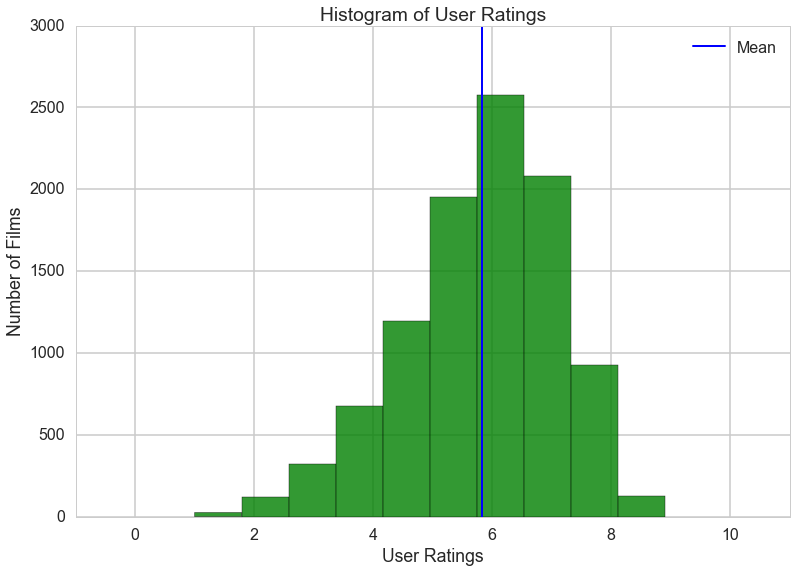

In [23]:
plt.hist(statsdf.user_ratings, color="Green", alpha=0.8)
plt.axvline(x=np.mean(statsdf.user_ratings), linewidth=2, color="blue",  label="Mean")
plt.title("Histogram of User Ratings")
plt.xlabel("User Ratings")
plt.ylabel("Number of Films")
plt.legend(loc='upper right')
plt.xlim([-1,11])

Now, we find the top 15 most popular filming locations. Most of these are countries, which is expected since country is a larger subset than city.

usa            4460
california     1637
los angeles    1153
new york        742
england         657
canada          570
india           507
germany         460
france          433
london          380
italy           334
spain           293
paris           237
ontario         234
australia       198
dtype: int64


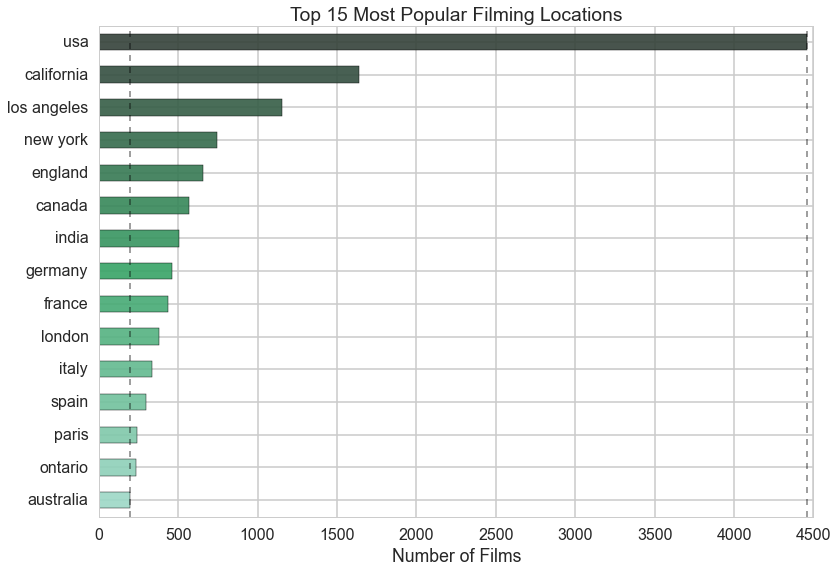

In [25]:
freq = Xsampleddf[Xsampleddf.columns[:-len(genres3)]].sum(axis=0)
sortfreq = freq.sort_values(ascending=False)
print sortfreq[0:15]
ax=(sortfreq[0:15]).plot('barh', color=sns.color_palette("BuGn_d", 15), alpha=0.9)
ax.invert_yaxis()
plt.title("Top 15 Most Popular Filming Locations")
plt.xlabel("Number of Films")
plt.axvline(x=min(sortfreq[0:15]), linewidth=1.5, alpha=0.5, linestyle="dashed", color="Black",  label="Minimum")
plt.axvline(x=max(sortfreq[0:15]), linewidth=1.5, alpha=0.5, linestyle="dashed", color="Black",  label="Minimum")

We are also interested in the average user ratings for these 15 locations.

In [26]:
mean15loc = list()
for loc in sortfreq[0:15].index:
    mean15loc.append(np.mean(statsdf[statsdf[str(loc)]==1].user_ratings))
    

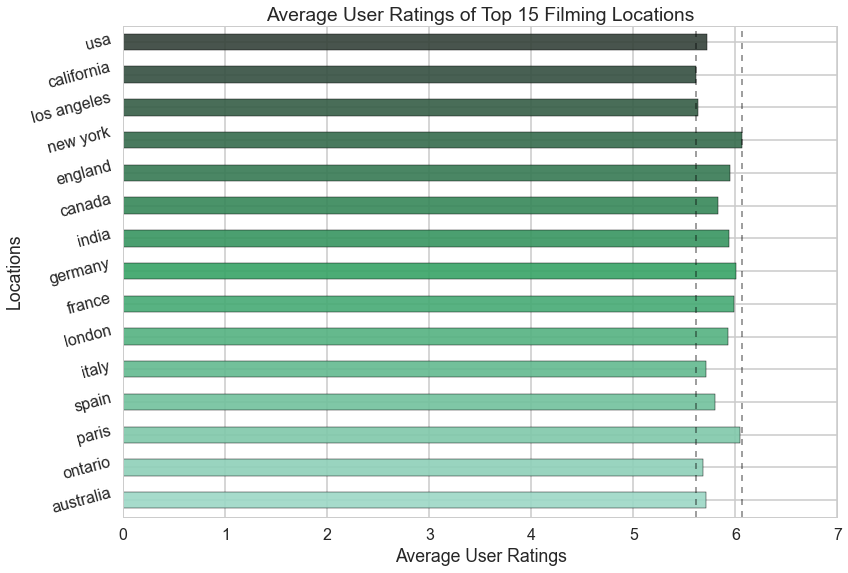

In [27]:
mean15loc_se = pd.Series(mean15loc,sortfreq[0:15].index)
mean15loc_se
ax=(mean15loc_se).plot('barh', color=sns.color_palette("BuGn_d", 15), alpha=0.9)
plt.title("Average User Ratings of Top 15 Filming Locations")
plt.xlabel("Average User Ratings")
plt.ylabel("Locations")
plt.yticks(rotation=15)
ax.invert_yaxis()
plt.axvline(x=min(mean15loc), linewidth=1.5, alpha=0.5, linestyle="dashed", color="Black",  label="Minimum")
plt.axvline(x=max(mean15loc), linewidth=1.5, alpha=0.5, linestyle="dashed", color="Black",  label="Minimum")

Next, the top 15 most frequent genres in our sample.

Drama        5107
Comedy       3048
Thriller     1684
Horror       1509
Action       1170
Romance      1168
Crime         813
Mystery       549
Adventure     519
Family        431
Fantasy       369
Biography     204
Music         203
History       190
War           135
dtype: int64


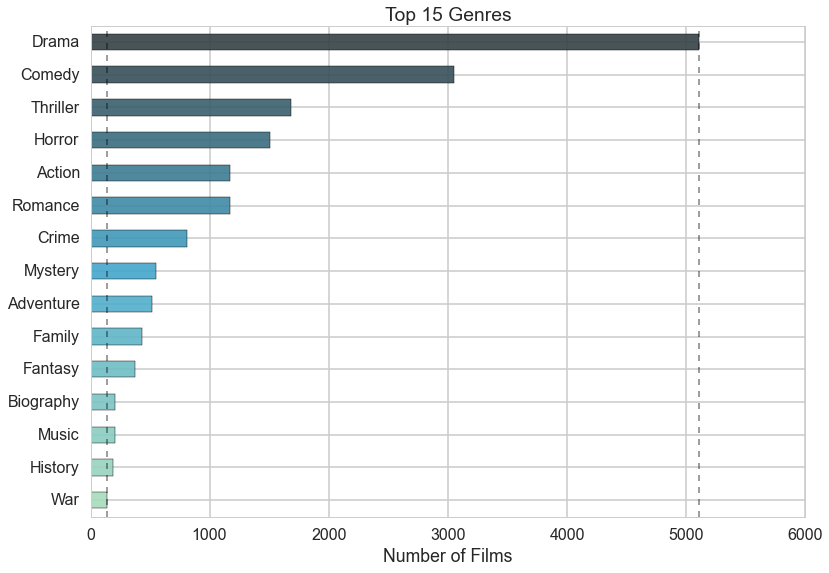

In [29]:
freq_g = Xsampleddf[Xsampleddf.columns[len(places3)+1:]].sum(axis=0)
sortfreq_g = freq_g.sort_values(ascending=False)
print sortfreq_g[0:15]
ax=(sortfreq_g[0:15]).plot('barh', color=sns.color_palette("GnBu_d", 15), alpha=0.9)
ax.invert_yaxis()
plt.title("Top 15 Genres")
plt.xlabel("Number of Films")
plt.axvline(x=min(sortfreq_g[0:15]), linewidth=1.5, alpha=0.5, linestyle="dashed", color="Black",  label="Minimum")
plt.axvline(x=max(sortfreq_g[0:15]), linewidth=1.5, alpha=0.5, linestyle="dashed", color="Black",  label="Minimum")

And the average user ratings for these 15 genres.

In [30]:
mean15gen = list()
for gen in sortfreq_g[0:15].index:
    mean15gen.append(np.mean(statsdf[statsdf[str(gen)]==1].user_ratings))

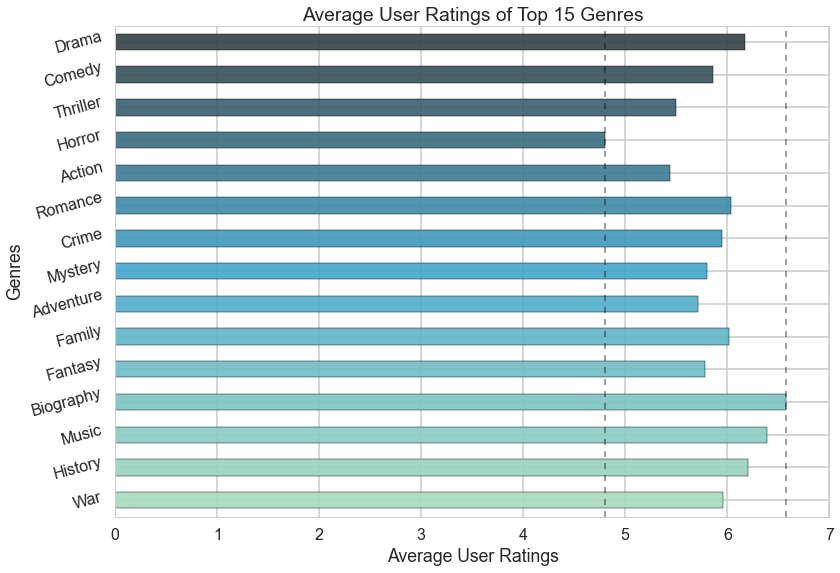

In [31]:
mean15gen_se = pd.Series(mean15gen,sortfreq_g[0:15].index)
mean15gen_se
ax=(mean15gen_se).plot('barh', color=sns.color_palette("GnBu_d", 15), alpha=0.9)
plt.title("Average User Ratings of Top 15 Genres")
plt.xlabel("Average User Ratings")
plt.ylabel("Genres")
plt.yticks(rotation=15)
ax.invert_yaxis()
plt.axvline(x=min(mean15gen), linewidth=1.5, alpha=0.5, linestyle="dashed", color="Black",  label="Minimum")
plt.axvline(x=max(mean15gen), linewidth=1.5, alpha=0.5, linestyle="dashed", color="Black",  label="Minimum")

## 3.2. Linear Regression

#### Tobit Censored Regression Model

Before performing the linear regression, it should be highlighted that because user ratings only fall within the range from "0" to "10", there is another regression model much more suited to estimating these relationships between user ratings and the features. That is the Tobit Censored Regression Model.

With Tobit, We denote $Y^*$= Latent Variable for User Ratings, $Y$= User Ratings, $L_l$ = Dummy Variable for Location $l$ and $G_g$ = Dummy Variable for Genre $g$. We estimate the following regression equation:

$$Y^*_i=\beta_0+\delta_1 L_{1i}+\delta_2 L_{2i}+...+\delta_C L_{Ci}+\gamma_1 G_{1i} + \gamma_2 G_{2i}+...+\gamma_G G_{Gi} + U_i$$

$$Y_i = [0,10]$$

where $\beta_0$ is the intercept parameter, $\delta_c$ are the slope parameters for the locations, $\gamma_g$ are the slope parameters for the genres and $U$ is the error term. $Y^*_i$, the latent variable, can take any value based on the equation. On the other hand, $Y_i$ can only take values between "0" and "10".

From the histogram of user ratings we plotted earlier, we know that the distribution of user ratings has the same shape as a normal distribution. So, we assume $U$ ~ $N(0, \sigma^2)$, lending credence to our gaussian assumption. The mechanics behind this regression are represented by the equations:

$$P(y=0|x) = 1 - \Phi(\frac{x\beta}{\sigma})$$

$$f(y|x) = \frac{1}{\sqrt{2\pi\sigma^2}}exp(-\frac{(y-x\beta)^2}{2\sigma^2})$$

$$P(y=10|x) = 1 - \Phi(\frac{10-x\beta}{\sigma})$$

where $x\beta$ denotes $\beta_0+\delta_1 L_{1i}+\delta_2 L_{2i}+...+\delta_C L_{Ci}+\gamma_1 G_{1i} + \gamma_2 G_{2i}+...+\gamma_G G_{Gi}$ and $\Phi$ is the standard normal probability function. These equations give us the probability of $y$ being "0" or "10" and the density function of $y$ for values between "0" and "10", given $x$.

However, we avoided the use of this model as the coefficients do not have direct and simple interpretations. Interpreting the partial effects is also problematic given that one can take the average partial effect (APE) or partial effect at the average (PEA). In addition, Statsmodel does not currently have a working Tobit model. Instead, it was recommended that Tobit be run on R first and the results imported. To avoid these complications, we chose to perform a linear regression model for its simplicity and direct interpretability of the coefficients.

#### Linear Regression

We begin by performing a linear regression of user ratings on the dummy variables for each location and genre. We do this so as to obtain easily interpretable coefficients of each feature. 

We wish to study the effects of locations and genre on user ratings. We denote $Y$= User Ratings, $L_l$ = Dummy Variable for Location $l$, $G_g$ = Dummy Variable for Genre $g$.

Our regression equation will take the following form:

$$Y_i=\beta_0+\delta_1 L_{1i}+\delta_2 L_{2i}+...+\delta_C L_{Ci}+\gamma_1 G_{1i} + \gamma_2 G_{2i}+...+\gamma_G G_{Gi}+U_i$$

where $\beta_0$ is the intercept parameter, $\delta_c$ are the slope parameters for the locations, $\gamma_g$ are the slope parameters for the genres and $U$ is the error term.

First, we split the data of user ratings, locations and genres into train and test data.

In [32]:
from sklearn.cross_validation import train_test_split
Xtrainl, Xtestl, ytrainl, ytestl = train_test_split(Xsampleddf, statsdf["user_ratings"], train_size=0.75, random_state=1)

In [33]:
model = sm.OLS(ytrainl, Xtrainl)
results = model.fit()

These are the features with coefficients that are statistically significant.

In [34]:
results.pvalues[results.pvalues<0.05].head()

jaipur          0.031044
chennai         0.005808
freudenstadt    0.034341
georgia         0.001751
ashford         0.019894
dtype: float64

These are the coefficients. Note the absurdity that some features increase user ratings by more than 10 points.

In [35]:
results.params[results.pvalues<0.05].sort_values(ascending=False).head()

loos            24.957358
szentendre      17.459086
biella          14.659172
mallaig         13.557582
fort william    13.191840
dtype: float64

Coefficient plots of the top 15 most popular locations

In [36]:
deslocs = sortfreq.sort_values(ascending=True)[-15::]

In [37]:
print deslocs.index

Index([u'australia', u'ontario', u'paris', u'spain', u'italy', u'london', u'france', u'germany', u'india', u'canada', u'england', u'new york', u'los angeles', u'california', u'usa'], dtype='object')


In [38]:
#Standard error for errorbars
xerr = results.bse[deslocs.index]
xerr

australia      0.380069
ontario        0.442441
paris          0.325786
spain          0.301113
italy          0.375365
london         0.313169
france         0.262132
germany        0.273910
india          0.192393
canada         0.227955
england        0.294713
new york       0.165300
los angeles    0.179086
california     0.200147
usa            0.147117
dtype: float64

In [39]:
#Coefficients
top15loc = results.params[deslocs.index]
top15loc

australia      3.426557
ontario        0.814143
paris         -0.457335
spain          2.521508
italy          0.388783
london        -0.768146
france         2.059562
germany        2.065136
india          2.925547
canada         2.599395
england        3.138369
new york      -0.567140
los angeles   -0.015699
california    -0.277162
usa            3.374355
dtype: float64

//anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


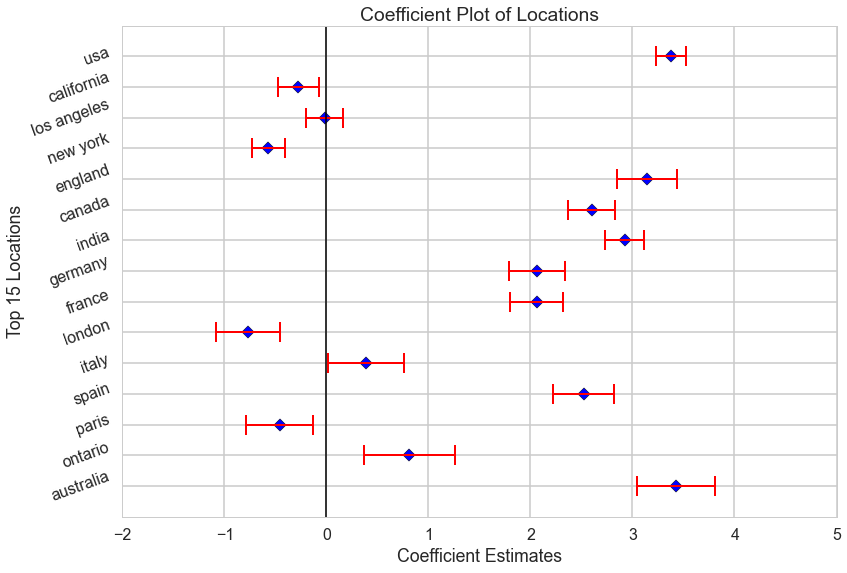

In [40]:
yaxis_loc = np.linspace(1,len(top15loc),len(top15loc))
plt.scatter(top15loc,yaxis_loc, s=75, marker="D")
plt.errorbar(top15loc, yaxis_loc,xerr=xerr, linestyle="None",elinewidth=2, capthick=2, capsize=10,c="red")
plt.title('Coefficient Plot of Locations')
plt.xlabel('Coefficient Estimates')
plt.ylabel('Top 15 Locations')
plt.yticks(yaxis_loc,top15loc.index)
plt.yticks(rotation=20)
plt.axvline(x=0, linewidth=1.5, color="black")

Coefficient plots of the top 15 most popular genres

In [41]:
desgen = sortfreq_g.sort_values(ascending=True)[-15::]

In [42]:
print desgen.index

Index([u'War', u'History', u'Music', u'Biography', u'Fantasy', u'Family', u'Adventure', u'Mystery', u'Crime', u'Romance', u'Action', u'Horror', u'Thriller', u'Comedy', u'Drama'], dtype='object')


In [43]:
xerr_genre = results.bse[desgen.index]
xerr_genre

War          0.301337
History      0.239929
Music        0.197332
Biography    0.261228
Fantasy      0.162765
Family       0.159836
Adventure    0.155442
Mystery      0.135940
Crime        0.115702
Romance      0.094690
Action       0.098749
Horror       0.095951
Thriller     0.088419
Comedy       0.071284
Drama        0.063693
dtype: float64

In [44]:
top15genre = results.params[desgen.index]
top15genre

War          0.098037
History      0.655510
Music        0.609088
Biography    0.320755
Fantasy      0.793675
Family       1.170839
Adventure    0.357039
Mystery      0.568049
Crime        0.506427
Romance      0.398571
Action       0.371962
Horror       0.524921
Thriller     1.079685
Comedy       1.833836
Drama        2.207334
dtype: float64

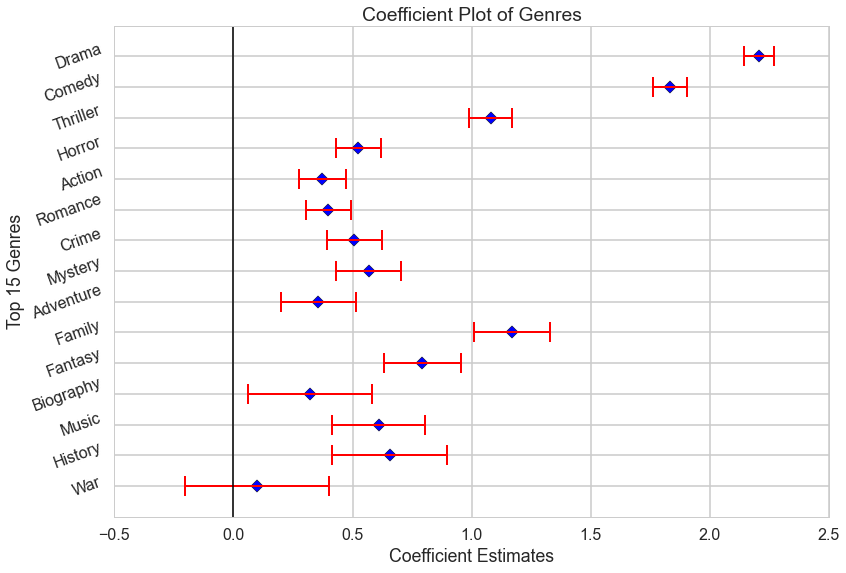

In [45]:
yaxis_genre = np.linspace(1,len(top15genre),len(top15genre))
plt.scatter(top15genre, yaxis_genre, s=75, marker="D")
plt.errorbar(top15genre,yaxis_genre,xerr=xerr_genre, linestyle="None",elinewidth=2, capthick=2, capsize=10,c="red")
plt.title('Coefficient Plot of Genres')
plt.xlabel('Coefficient Estimates')
plt.ylabel('Top 15 Genres')
plt.yticks(yaxis_genre, top15genre.index )
plt.yticks(rotation=20)
plt.axvline(x=0, linewidth=1.5, color="black")

We refit the model using only statistically significant features and predict user ratings using our test data.

In [46]:
model2 = sm.OLS(ytrainl, Xtrainl[results.pvalues[results.pvalues<0.05].index])
results2 = model2.fit()

In [47]:
ypredl = results2.predict(Xtestl[results.pvalues[results.pvalues<0.05].index])

An overlay of the histograms of the actual and predicted user ratings of our test set shows us how good our prediction is.

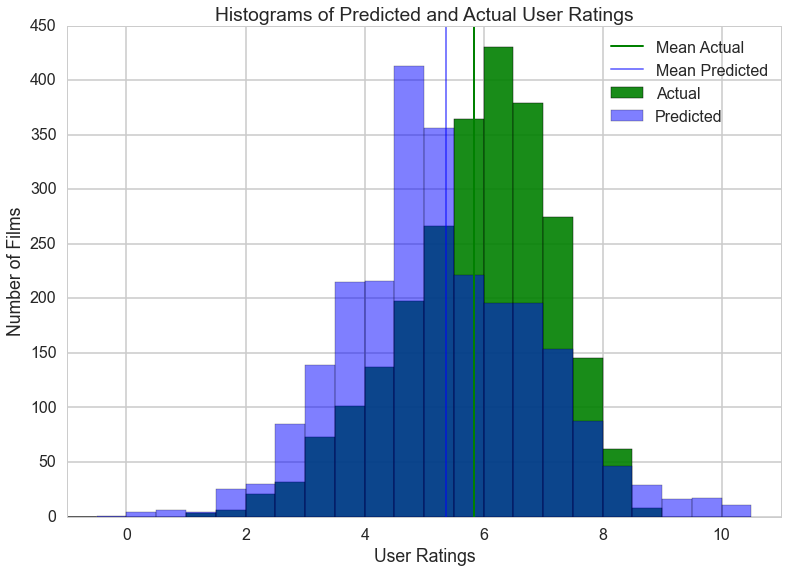

In [51]:
plt.axvline(x=np.mean(ytestl.values), linewidth=2, color="green", label="Mean Actual")
plt.axvline(x=np.mean(ypredl), linewidth=2,alpha=0.5, color="blue", label="Mean Predicted")
plt.hist(ytestl.values,bins=np.arange(-1, 11, 0.5),alpha=0.9, label='Actual', color="green")
plt.hist(ypredl, bins=np.arange(-1, 11, 0.5), alpha=0.5, label='Predicted', color="blue")
plt.legend(loc='upper right')
plt.xlabel("User Ratings")
plt.ylabel("Number of Films")
plt.xlim([-1,11])
plt.title("Histograms of Predicted and Actual User Ratings")
plt.show()

## 3.3. Principal Component Analysis

We begin analysis by using PCA to reduce the number of dimensions features in the data. Our variation cutoff will be 5%. So if variation falls below 5% after a certain component, we will remove all remaining dimensions.

In [52]:
from sklearn.decomposition import PCA

pca = PCA(n_components=1500)

new_X = pca.fit_transform(Xsampleddf)

In [38]:
pca.explained_variance_ratio_
print pca.explained_variance_ratio_.sum()

0.950989475389


In [39]:
Xdf = pd.DataFrame()

for i in range(pca.explained_variance_ratio_.shape[0]):
    Xdf["pc%i" % (i+1)] = new_X[:,i]

In [40]:
Xdf.head()

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,pc11,pc12,pc13,pc14,pc15,pc16,pc17,pc18,pc19,pc20,pc21,pc22,pc23,pc24,pc25,pc26,pc27,pc28,pc29,pc30,pc31,pc32,pc33,pc34,pc35,pc36,pc37,pc38,pc39,pc40,pc41,pc42,pc43,pc44,pc45,pc46,pc47,pc48,pc49,pc50,...,pc1451,pc1452,pc1453,pc1454,pc1455,pc1456,pc1457,pc1458,pc1459,pc1460,pc1461,pc1462,pc1463,pc1464,pc1465,pc1466,pc1467,pc1468,pc1469,pc1470,pc1471,pc1472,pc1473,pc1474,pc1475,pc1476,pc1477,pc1478,pc1479,pc1480,pc1481,pc1482,pc1483,pc1484,pc1485,pc1486,pc1487,pc1488,pc1489,pc1490,pc1491,pc1492,pc1493,pc1494,pc1495,pc1496,pc1497,pc1498,pc1499,pc1500
0,-0.066350,-0.670093,-0.050836,0.078633,-1.125600,-0.056040,-0.105434,0.190272,0.538619,-0.195652,-0.399023,-0.164460,-0.293033,-0.027973,0.122600,0.037682,0.003890,-0.031325,-0.011806,0.046461,-0.056476,-0.053256,0.008578,0.044745,-0.100227,0.071823,0.046617,0.066691,0.062903,0.000380,0.164204,-0.069500,-0.098806,0.166479,-0.150137,0.079788,-1.153106,-0.104587,-0.621643,-0.072449,0.047920,-0.040244,-0.065587,0.058357,0.000321,-0.000242,-0.021478,-0.027888,0.076853,0.009436,...,-0.000438,-0.002407,0.001025,0.002078,0.000568,-0.000128,0.000520,-0.002168,0.002026,-0.001497,-0.002197,-0.001142,0.000665,0.000840,-0.000200,0.001133,0.001909,-0.000977,0.000437,-0.001389,-0.001871,-0.000345,0.001306,0.000659,0.001392,-0.001358,-0.000818,0.001093,-0.000189,0.000809,-0.000589,0.000197,-0.000129,0.000094,0.000048,-0.001028,-0.000985,-0.000508,0.000316,-0.000454,0.000286,-0.000285,-0.000136,5.545358e-15,-1.071335e-15,8.011229e-17,2.192823e-15,-2.000105e-15,3.678057e-15,4.806914e-17
1,-0.560812,0.531123,0.382659,0.333944,-0.439023,0.241006,-0.316783,0.065685,0.135553,-0.021532,-0.771417,-0.326313,-0.164382,-0.026190,0.103695,0.084151,-0.096116,0.168581,0.021410,-0.009517,-0.020731,0.033012,-0.034160,0.054860,-0.053168,0.011908,-0.023070,0.023686,-0.010562,0.020057,-0.055836,0.003963,-0.053014,0.096105,-0.028106,-0.033452,0.033938,0.007513,-0.026669,0.034174,-0.029366,0.021898,0.011461,-0.025068,-0.001814,0.005328,0.018447,0.001233,0.018085,0.008192,...,0.006794,0.006914,0.005465,-0.000749,0.003412,0.007277,0.002803,0.003248,0.006883,-0.002268,0.000807,-0.000491,0.003035,0.006386,0.000034,-0.000559,0.003034,-0.003492,0.000237,-0.001926,-0.002465,0.000450,-0.001249,0.002407,0.000779,-0.004617,0.000620,-0.003264,-0.001933,0.001040,0.001819,0.001321,-0.001332,0.001044,-0.001357,0.001890,-0.001539,0.001206,-0.000218,-0.001807,-0.000571,-0.001234,-0.000651,-4.630789e-15,-8.194638e-15,1.200081e-15,2.935721e-15,3.506154e-15,1.522058e-15,-5.373756e-16
2,0.610763,-0.315403,-0.474722,-0.212557,0.035915,0.524099,-0.173022,-0.202003,-0.186362,-0.111612,0.462814,-0.012471,-0.039386,-0.038874,-0.399794,0.047593,-0.805383,0.360135,-0.076638,-0.156924,0.414043,0.139779,-0.321184,0.235991,0.442186,0.351778,0.342874,0.189957,0.033711,0.017275,0.737087,0.313009,-0.201215,0.233734,-0.029612,0.108084,0.090686,-0.022965,0.065336,0.012187,-0.055115,0.037796,0.054085,-0.055087,0.015385,0.008298,0.013550,0.009909,-0.006662,0.008863,...,0.009580,0.008613,-0.001274,-0.008282,0.000454,0.004485,-0.007032,-0.014146,-0.002670,0.008665,0.017603,-0.008668,0.005087,-0.000927,-0.005786,0.025804,0.009820,0.039011,0.012167,-0.080612,-0.005553,0.001007,0.007712,0.004880,-0.010619,0.026855,0.042320,0.013477,-0.019962,0.022043,0.009657,-0.023286,0.036905,0.011638,-0.012916,0.004692,-0.004997,-0.002481,0.020375,0.002992,-0.008840,0.002359,0.005339,6.705348e-15,8.061745e-15,4.665459e-15,-1.428342e-14,4.616225e-15,-2.493985e-14,-2.236853e-15
3,0.117680,0.499039,-0.666343,0.104795,0.429531,-0.598048,0.014088,-0.014096,0.173909,-0.139098,-0.152528,0.097668,0.120513,-0.009330,0.121165,-0.072110,-0.102072,-0.034262,0.052635,0.009866,0.080861,0.054988,0.001523,-0.011362,-0.001016,0.009547,-0.024669,-0.061805,-0.060235,0.011753,-0.009676,-0.018192,0.028999,-0.019510,0.033466,0.009968,-0.011181,0.009403,-0.021586,-0.018842,0.026755,-0.009931,-0.021578,0.037902,0.011662,0.012444,0.001497,-0.020722,0.0194

This gives us a data set with reduced dimension. Now, the features are the principal components.

##3.4. Train-Test Splitting

Here, we split our data set into train and test sets. Our data set consists of 10,000 titles. We want training and testing data in the ratio 3:1. So, the size of each set will be 4,500 and 1,500, respectively.

In [41]:
from sklearn.cross_validation import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(Xdf.values, ratingsdf_sampled['reception'].values, train_size=0.75, random_state=1)

##3.5. Baseline Accuracy

We calculate a baseline accuracy by assuming that all the predictions were well-received. This gives us a baseline of:

In [42]:
baseline  = sum(ytest)*1./len(ytest)
print 'Baseline Accuracy: %0.4f' % baseline

Baseline Accuracy: 0.7716


For our classifier to to worthwhile pursuing, the classifier's accuracy should be better than the baseline. This is what we will explore in the next few sections using logistic regression and KNN.

##3.6. Logistic Regression

We wish to study the effects of locations and genre on category. Since we have reduced locations and genres to principal components, we will perform a logistic regression of film reception on the principal components. We denote $ Y = $ Reception and $PC_c$ = Dummy Variable for principal component $c$.

Our regression equation will take the following form:

$$ P(Y_i=1) = F(\beta_0 + \delta_1 PC_{1i} + \delta_2 PC_{2i} + ... + \delta_C PC_{Ci})$$

where $\beta_0$ is the intercept parameter, $\delta_c$ are the slope parameters for the principal components and $F$ is the logistic function defined as:

$$ F(x) = \frac{e^x}{e^x + 1} $$

After estimating the coefficients, we apply the coefficient estimates on the test set. Then, we compare the accuracy of predicting $Y$ on both the training and test data.

In the code below, we first find the best paramater C for the logistic regression from the training set using 5-folds cross-validation.

In [43]:
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

clf=LogisticRegression()
parameters = {"C": [0.0001, 0.001, 0.1, 1, 10, 100]}
fitmodel = GridSearchCV(clf, param_grid=parameters, cv=5, scoring="accuracy")
fitmodel.fit(Xtrain, ytrain)
fitmodel.best_estimator_, fitmodel.best_params_, fitmodel.best_score_, fitmodel.grid_scores_

(LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr',
           penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
           verbose=0),
 {'C': 0.1},
 0.77800000000000002,
 [mean: 0.76507, std: 0.00021, params: {'C': 0.0001},
  mean: 0.76507, std: 0.00021, params: {'C': 0.001},
  mean: 0.77800, std: 0.00664, params: {'C': 0.1},
  mean: 0.77613, std: 0.00724, params: {'C': 1},
  mean: 0.75320, std: 0.00768, params: {'C': 10},
  mean: 0.73093, std: 0.00899, params: {'C': 100}])

In [180]:
clflog=LogisticRegression(C=fitmodel.best_params_['C'])
clflog.fit(Xtrain, ytrain)
lrtrain_accuracy = clflog.score(Xtrain,ytrain)
lrtest_accuracy=clflog.score(Xtest,ytest)
print "Accuracy on training data: %0.4f" % (lrtrain_accuracy)
print "Accuracy on test data:     %0.4f" % (lrtest_accuracy)

Accuracy on training data: 0.7889
Accuracy on test data:     0.7884


In [181]:
from sklearn.metrics import roc_curve, auc
def make_roc(name, clf, ytest, xtest, ax=None, labe=5, proba=True, skip=0):
    initial=False
    if not ax:
        ax=plt.gca()
        initial=True
    if proba:#for stuff like logistic regression
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
    else:#for stuff like SVM
        fpr, tpr, thresholds=roc_curve(ytest, clf.decision_function(xtest))
    roc_auc = auc(fpr, tpr)
    if skip:
        l=fpr.shape[0]
        ax.plot(fpr[0:l:skip], tpr[0:l:skip], '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    else:
        ax.plot(fpr, tpr, '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    label_kwargs = {}
    label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.3', alpha=0.2,
    )
    if labe!=None:
        for k in xrange(0, fpr.shape[0],labe):
            #from https://gist.github.com/podshumok/c1d1c9394335d86255b8
            threshold = str(np.round(thresholds[k], 2))
            ax.annotate(threshold, (fpr[k], tpr[k]), **label_kwargs)
    if initial:
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC')
    ax.legend(loc="lower right")
    return ax

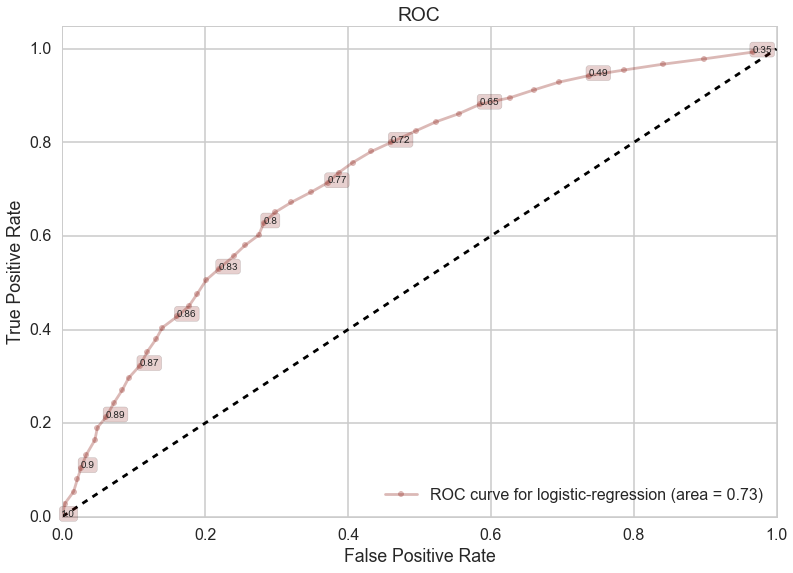

In [182]:
with sns.hls_palette(8, l=.3, s=.8):
    ax=make_roc("logistic-regression",clflog, ytest, Xtest, labe=200, skip=50)

##3.7. K-Nearest Neighbours

Next, we use the non-parametrised kNN classification with distance defined by the principal components. We train the data and use cross-validation to find the optimal K. Then, we look at the accuracy of prediction on the test data, comparing it with the training data.

In [47]:
from sklearn.neighbors import KNeighborsClassifier

clf= KNeighborsClassifier()
k = {}

This is the code to find the optimal k neighbours from training set:

In [48]:
#coarse grain search
gs = GridSearchCV(KNeighborsClassifier(), param_grid={"n_neighbors": range(1,86,20)}, cv=5)
gs.fit(Xtrain, ytrain)
gs.best_params_, fitmodel.best_score_, fitmodel.grid_scores_
for scores in gs.grid_scores_:
    k[scores[1]] = (scores[0])['n_neighbors']
k_best = k[max(k.keys())]

In [49]:
#fine grain search
gs = GridSearchCV(KNeighborsClassifier(), param_grid={"n_neighbors": range(k_best-8,k_best+8,2)}, cv=5)
gs.fit(Xtrain, ytrain)
gs.best_params_, fitmodel.best_score_, fitmodel.grid_scores_
for scores in gs.grid_scores_:
    k[scores[1]] = (scores[0])['n_neighbors']

In [50]:
k

{0.68666666666666665: 1,
 0.76759999999999995: 21,
 0.77573333333333339: 41,
 0.77759999999999996: 61,
 0.77813333333333334: 73,
 0.77839999999999998: 87,
 0.7785333333333333: 77,
 0.77880000000000005: 85,
 0.77906666666666669: 81,
 0.78000000000000003: 83}

In [51]:
k_best = k[max(k.keys())]
k_best

83

Then we apply to the test set and compare the accuracy with logistic regression.

In [183]:
clfknn=KNeighborsClassifier(n_neighbors=k_best)
#clfknn=KNeighborsClassifier(n_neighbors=83)
clfknn = clfknn.fit(Xtrain, ytrain)
ktrain_accuracy = clflog.score(Xtrain,ytrain)
ktest_accuracy = clfknn.score(Xtest,ytest)
print "Accuracy on training data: %0.4f" % (ktrain_accuracy)
print "Accuracy on test data:     %0.4f" % (ktest_accuracy)


Accuracy on training data: 0.7889
Accuracy on test data:     0.7760


#4. Comparison

In [241]:
accuracies = {}
accuracies["Baseline"] = [round(baseline, 4)]*100
accuracies["Logistic Regression"] = [round(lrtest_accuracy,4)]*100
accuracies["kNN"]= [round(ktest_accuracy, 4)]*100
accuracies
sortedvalues = sorted(accuracies.values())

,Baseline,Logistic Regression,kNN
0,0.7716,0.7884,0.776


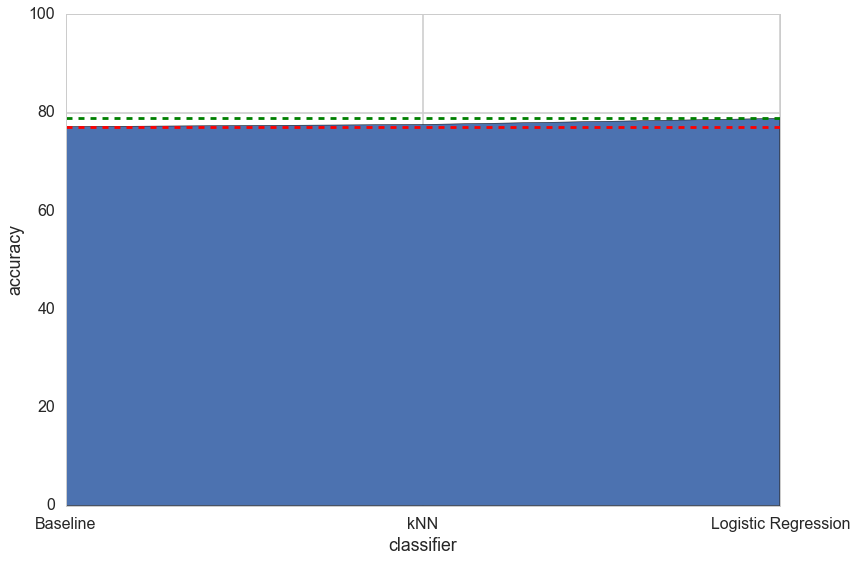

In [135]:
plt.fill_between(np.arange(3),sortedvalues)
plt.ylim(0,100)
plt.axhline(y=accuracies['Baseline'],linestyle='--',color='red')
plt.axhline(y=accuracies['Logistic Regression'],linestyle='--',color='green')
plt.xticks(np.arange(3), ['Baseline','kNN','Logistic Regression'] )
plt.ylabel('accuracy')
plt.xlabel('classifier')